In [1]:
import torch
import torch.nn as nn
import numpy as np
from copy import deepcopy

device = "cuda" if torch.cuda.is_available() else "cpu"

class RBFlayer(nn.Module):
    def __init__(self, timelag):
        super(RBFlayer, self).__init__()

        self.timelag = timelag

        device = "cuda" if torch.cuda.is_available() else "cpu"
        torch.cuda.manual_seed(0)

        self.init_weight_cause = nn.Parameter(torch.rand(self.timelag, device=device))
        self.init_weight_target = nn.Parameter(torch.rand(self.timelag, device=device))
        self.cause_clt = self.init_clt()
        self.cause_std = self.init_clt()
        self.target_clt = nn.Parameter(torch.rand(1, device=device))
        self.target_std = nn.Parameter(torch.rand(1, device=device))

    def init_clt(self):
        return nn.Parameter(torch.rand(1, device=device))

    def init_std(self):
        return nn.Parameter(torch.rand(1, device=device))

    def rbf(self, x, cluster, std):
        return torch.exp(-(x - cluster) * (x - cluster) / 2 * (std * std))
    
    def rbf_gradient(self, x, clt, std):
        return (-2 * (x - clt) / (std * std)) * (torch.exp(-(x - clt) * (x - clt) / 2 * (std * std)))
    
    def rbf_grad(self, x, type_ = 'cause'):
        
        # 1~ x.shape[0]-2th gradient list
        
        rbf_grad_list = []
        if type_ == "cause":
            for j in range(x.shape[0] - 2):
                rbf_grad_list.append(self.rbf_gradient(x[j+1], self.cause_clt, self.cause_std))
        
        else:
            for j in range(x.shape[0] - 2):
                rbf_grad_list.append(self.rbf_gradient(x[j+1], self.target_clt, self.target_std))
        
        return rbf_grad_list
    
    def rbf_num_grad(self, x, type_ = "cause"):
        
        rbf_grad_list = []
        if type_ == "cause":
            for j in range(x.shape[0] - 2):
                rbf_grad_list.append(self.rbf(x[j+2], self.cause_clt, self.cause_std) - self.rbf(x[j], self.cause_clt, self.cause_std))
                
        else:
            for j in range(x.shape[0] - 2):
                rbf_grad_list.append(self.rbf(x[j+2], self.target_clt, self.target_std) - self.rbf(x[j], self.target_clt, self.target_std))
                
        return rbf_grad_list


    def forward(self, cause, target):

        for i in range(len(cause)):
            if i == 0:
                a = self.rbf(cause[i], self.cause_clt, self.cause_std)
            else:
                a = torch.cat([a, self.rbf(cause[i], self.cause_clt, self.cause_std)], dim=0)
        cause = self.init_weight_cause * a

        for j in range(len(target)):
            if j == 0:
                b = self.rbf(target[j], self.target_clt, self.target_std)
            else:
                b = torch.cat([b, self.rbf(target[j], self.target_clt, self.target_std)], dim=0)
        target = self.init_weight_target * b

        return cause, target


class RBFnet(nn.Module):
    def __init__(self, input_size , output_size, timelag):
        super(RBFnet,self).__init__()

        self.input_size = input_size      # number of data
        self.output_size = output_size
        self.timelag = timelag

        self.linear = nn.ModuleList([nn.Linear(self.timelag*2,1) for _ in range(self.input_size)])
        self.relu = nn.ReLU()
        self.networks = nn.ModuleList([RBFlayer(self.timelag) for _ in range(self.input_size)])

    def cause_target(self, cause, target):
        x = torch.cat((cause, target), 0)

        return x

    def GC(self, threshold=True):
        '''
        Extract learned Granger causality.
        Args:
          threshold: return norm of weights, or whether norm is nonzero.
        Returns:
          GC: (p x p) matrix. Entry (i, j) indicates whether variable j is
            Granger causal of variable i.
        '''
        GC = [torch.norm(net.init_weight_cause, dim=0)
              for net in self.networks]
        GC = torch.stack(GC)
        if threshold:
            return (GC > 0).int()
        else:
            return GC


    def forward(self, causes, targets):
        out_list = []
        for i in range(self.input_size):
            cause, target = self.networks[i](causes[i], targets[i])
            cause, target = self.relu(cause), self.relu(target)
            pred = torch.cat((cause, target),0)
            pred = self.linear[i](pred)
            out_list.append(pred)

        return out_list




In [2]:
def restore_parameters(model, best_model):
    '''Move parameter values from best_model to model.'''
    for params, best_params in zip(model.parameters(), best_model.parameters()):
        params.data = best_params

def train_rbf(model, input_causes, input_targets, Y, lr, epochs, lookback=5,device = device):
    # input_causes, input_targets : X
    # Y : Y
    model.to(device)
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss_list = []

    best_it = None
    best_model = None
    best_loss = np.inf
    time = torch.tensor([0,1,2,3,4,5,6,7,8,9], device = device)

    for epoch in range(epochs):
        loss_cause = 0
        loss_target = 0
        
        # pred loss
        pred = model(input_causes, input_targets)
        loss_ = sum([loss_fn(pred[i], Y[i]) for i in range(len(Y))])
        
        # cause gradient loss
        for i in range(len(model.networks)):
            rbf_num_list = model.networks[i].rbf_num_grad(time, "cause")
            rbf_fn_grad = model.networks[i].rbf_grad(time, "cause")
            
            loss_cause += sum([loss_fn(rbf_fn_grad[j], rbf_num_list[j]) for j in range(len(rbf_num_list))])
        
        # target gradient loss
        for i in range(len(model.networks)):
            rbf_num_list = model.networks[i].rbf_num_grad(time, "target")
            rbf_fn_grad = model.networks[i].rbf_grad(time, "target")
            
            loss_target += sum([loss_fn(rbf_fn_grad[j], rbf_num_list[j]) for j in range(len(rbf_num_list))])
        
        print("epoch {} loss {} :".format(epoch, loss_ / len(Y)))
        print("epoch {} cause loss {}".format(epoch, loss_cause / len(Y)))
        print("epoch {} target loss {}".format(epoch, loss_target / len(Y)))

        
        loss = loss_ + loss_cause + loss_target
        print("epoch {} loss {} :".format(epoch, loss / len(Y)))
        print("------------------------------------------------------")
        print()
              
        # loss = loss_target
        '''
        loss_.backward()
        optimizer.step()
        
        loss_cause.backward()
        optimizer.step()
        
        loss_target.backward()
        optimizer.step()
        '''
        
        loss.backward()
        optimizer.step()
        model.zero_grad()

        
        mean_loss = loss / len(Y)
        train_loss_list.append(mean_loss)
        if mean_loss < best_loss:
            best_loss = mean_loss
            best_it = epoch
            best_model = deepcopy(model)
        elif (epoch - best_it) == lookback:
            if verbose:
                print('Stopping early')
            break

    restore_parameters(model, best_model)

    return train_loss_list , model

In [3]:
def data_split(X, cause, target, timelag, device = device):
    input_cause = []
    input_target = []
    Y = []

    for i in range(len(X) - (timelag + 1)):
        input_cause.append(X[cause].values[i: i + timelag])
        input_target.append(X[target].values[i: i + timelag])
        Y.append([X[target][i + timelag + 1]])

    return torch.tensor(input_cause, device=device).float(), torch.tensor(input_target,device=device).float(), torch.tensor(Y, device=device).float()


In [4]:
import pandas as pd
df = pd.read_csv('C:/Users/chanyoung/Desktop/Neural-GC-master/lorenz_96_10_10_1000.csv')
X2d = df[['a','b']]
torch.manual_seed(1234)
input_cause, input_target, Y = data_split(X2d, 'a', 'b', 10)

In [5]:
model = RBFnet(input_cause.size()[0], 1, input_cause.size()[1])
print(model.networks[1].init_weight_cause)
print(model.networks[1].cause_std)
print(model.networks[1].target_std)
loss, best_model = train_rbf(model, input_cause, input_target, Y, 0.01, 10, device)
print(best_model.networks[1].init_weight_cause)
print(best_model.networks[1].cause_std)
print(model.networks[1].target_std)

Parameter containing:
tensor([0.3990, 0.5167, 0.0249, 0.9401, 0.9459, 0.7967, 0.4150, 0.8203, 0.2290,
        0.9096], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.7874], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.4503], device='cuda:0', requires_grad=True)
epoch 0 loss 27.48686408996582 :
epoch 0 cause loss 4.287822246551514
epoch 0 target loss 434.9068603515625
epoch 0 loss 466.6815490722656 :
------------------------------------------------------

epoch 1 loss 27.025388717651367 :
epoch 1 cause loss 3.7400200366973877
epoch 1 target loss 370.09320068359375
epoch 1 loss 400.8586120605469 :
------------------------------------------------------

epoch 2 loss 26.581005096435547 :
epoch 2 cause loss 3.258711576461792
epoch 2 target loss 316.2395935058594
epoch 2 loss 346.07928466796875 :
------------------------------------------------------

epoch 3 loss 26.152889251708984 :
epoch 3 cause loss 2.8372271060943604
epoch 3 target loss 271.

In [6]:
time = torch.tensor([0,1,2,3,4,5,6,7,8,9], device = device)
best_model.networks[0].rbf_num_grad(time, "cause")

[tensor([-0.8106], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([-0.6116], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([-0.1855], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([-0.0252], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([-0.0016], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([-4.4848e-05], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([-5.8956e-07], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([-3.5646e-09], device='cuda:0', grad_fn=<SubBackward0>)]

In [8]:
best_model.networks[0].rbf_grad(time, "cause")

[tensor([-1.7680], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([-1.0008], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([-0.2002], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([-0.0165], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([-0.0006], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([-9.2283e-06], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([-6.4977e-08], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([-2.0624e-10], device='cuda:0', grad_fn=<MulBackward0>)]

In [12]:
input_cause[0]

tensor([ 0.0990,  2.3833,  6.1237,  8.7908,  8.6702,  8.3957,  6.3754,  0.7887,
        -3.0315, -3.0010], device='cuda:0')

In [9]:
best_model.networks[0].cause_std

Parameter containing:
tensor([0.8812], device='cuda:0', requires_grad=True)

In [10]:
best_model.networks[0].cause_clt

Parameter containing:
tensor([-0.0779], device='cuda:0', requires_grad=True)

In [11]:
def rbf(x, cluster, std):
    return torch.exp(-(x - cluster) * (x - cluster) / 2 * (std * std))

In [14]:
a = rbf(input_cause[0], best_model.networks[0].cause_clt, best_model.networks[0].cause_std)

In [20]:
a

tensor([9.8792e-01, 9.5180e-02, 3.2686e-07, 5.4479e-14, 1.2437e-13, 7.7950e-13,
        9.4885e-08, 7.4705e-01, 3.3794e-02, 3.6235e-02], device='cuda:0',
       grad_fn=<ExpBackward>)

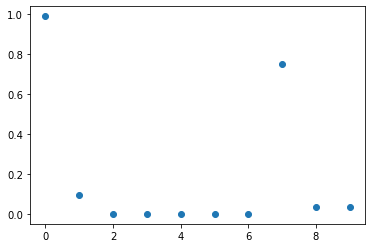

In [22]:
import matplotlib.pyplot as plt
plt.scatter([0,1,2,3,4,5,6,7,8,9],a.detach().cpu())

In [31]:
input_cause[0]

tensor([ 0.0990,  2.3833,  6.1237,  8.7908,  8.6702,  8.3957,  6.3754,  0.7887,
        -3.0315, -3.0010], device='cuda:0')

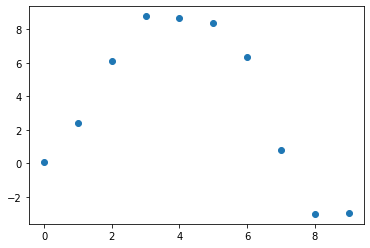

In [30]:
plt.scatter([0,1,2,3,4,5,6,7,8,9],input_cause[0].detach().cpu())

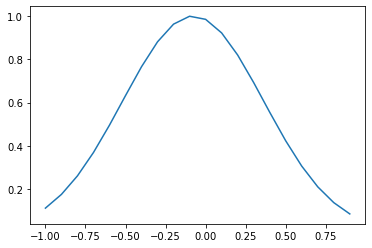

In [29]:
x = np.arange(-1, 1, 0.1)
y = [np.exp(-(b + 0.0779)*(b +0.0779) /0.8812**2 *2) for b in x]
plt.plot(x,y)